### Clase 7: Laboratorio

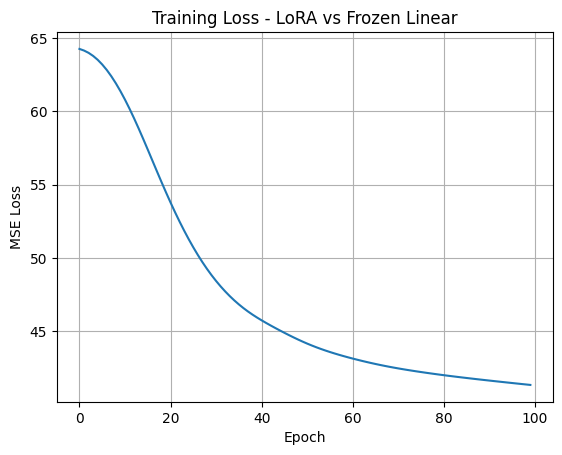

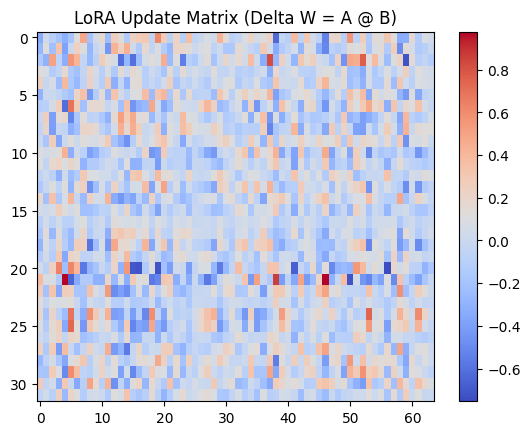

frozen.weight: requires_grad = False
frozen.bias: requires_grad = False
A.weight: requires_grad = True
B.weight: requires_grad = True

Frozen W grad: None


In [4]:
# LoRA manual: fine-tuning a linear layer with low-rank adaptation

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

# Simulated input and target
x = torch.randn(64, 64)  # batch of 64, input dim 64
target = torch.randn(64, 32)  # target output

# Original linear layer (frozen)
class FrozenLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.weight.requires_grad = False
        self.bias.requires_grad = False

    def forward(self, x):
        return F.linear(x, self.weight, self.bias)

# LoRA module manually implemented
class LoRALinear(nn.Module):
    def __init__(self, frozen_layer, r=4, alpha=8):
        super().__init__()
        self.frozen = frozen_layer
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r
        in_features = frozen_layer.weight.shape[1]
        out_features = frozen_layer.weight.shape[0]

        self.A = nn.Linear(in_features, r, bias=False)
        self.B = nn.Linear(r, out_features, bias=False)

        nn.init.kaiming_uniform_(self.A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.B.weight)

    def forward(self, x):
        return self.frozen(x) + self.scaling * self.B(self.A(x))

# Instantiate model and optimizer
frozen_layer = FrozenLinear(64, 32)
lora_layer = LoRALinear(frozen_layer)
optimizer = torch.optim.Adam(lora_layer.parameters(), lr=1e-2)

# Training loop and loss tracking
losses = []
for epoch in range(100):
    optimizer.zero_grad()
    output = lora_layer(x)
    loss = F.mse_loss(output, target)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Plot training loss
plt.plot(losses)
plt.title("Training Loss - LoRA vs Frozen Linear")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

# Visualize low-rank update matrix (Delta W = A @ B)
with torch.no_grad():
    A = lora_layer.A.weight  # [r, in_features]
    B = lora_layer.B.weight  # [out_features, r]
    delta_W = (A.T @ B.T)    # [in_features, out_features] --> transpose for [out, in]
    delta_W = delta_W.T      # final shape [32, 64]

plt.imshow(delta_W.detach().numpy(), aspect='auto', cmap='coolwarm')
plt.title("LoRA Update Matrix (Delta W = A @ B)")
plt.colorbar()
plt.show()

# Print what gets trained
for name, param in lora_layer.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

# Confirm frozen base layer does not receive gradients
print("\nFrozen W grad:", frozen_layer.weight.grad)  # Should be None


In [1]:
# Laboratorio Comparativo: Fine-tuning completo vs. LoRA para resumen automático

# 1. Setup (ya realizado antes)
from datasets import load_dataset
from transformers import AutoTokenizer, T5ForConditionalGeneration

model_id = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_id)

dataset = load_dataset("xsum")
dataset = dataset["train"].select(range(300)).train_test_split(test_size=0.1)

max_input_length = 128
max_target_length = 32

def preprocess(example):
    inputs = ["summarize: " + doc for doc in example["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, padding="max_length", truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(example["summary"], max_length=max_target_length, padding="max_length", truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=dataset["train"].column_names)

# 2. Fine-tuning completo
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import evaluate
import numpy as np
import torch

model_full = T5ForConditionalGeneration.from_pretrained(model_id)

metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    preds_ids = predictions.argmax(-1)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds_ids, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v * 100, 2) for k, v in result.items()}

args_full = Seq2SeqTrainingArguments(
    output_dir="./flan_full",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="no",
    report_to="none",
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_full)

trainer_full = Seq2SeqTrainer(
    model=model_full,
    args=args_full,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_full.train()

# 3. Inferencia (modelo completo)
model_full = model_full.to("cpu")
sample = dataset["test"][0]["document"]
input_ids = tokenizer("summarize: " + sample, return_tensors="pt").input_ids.to("cpu")

output_full = model_full.generate(input_ids, max_length=64)
summary_full = tokenizer.decode(output_full[0], skip_special_tokens=True)

print("\nTexto original:\n", sample[:500])
print("\nResumen generado (Fine-tuning completo):\n", summary_full)

# 4. Reentrenamiento LoRA para comparación
from peft import LoraConfig, get_peft_model, TaskType

base_model = T5ForConditionalGeneration.from_pretrained(model_id)
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)

model_lora = get_peft_model(base_model, lora_config)
model_lora.print_trainable_parameters()

args_lora = Seq2SeqTrainingArguments(
    output_dir="./flan_lora",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="no",
    report_to="none",
)

trainer_lora = Seq2SeqTrainer(
    model=model_lora,
    args=args_lora,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_lora.train()

# 5. Inferencia LoRA
model_lora = model_lora.to("cpu")
output_lora = model_lora.base_model.generate(input_ids, max_length=64)
summary_lora = tokenizer.decode(output_lora[0], skip_special_tokens=True)

print("\nResumen generado (LoRA):\n", summary_lora)


W0520 22:05:14.929000 22435 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/fdiazja/nlp_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/fdiazja/nlp_env/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for xsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xsum
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Map:   0%|          | 0/270 [00:00<?, ? examples/s]

/Users/fdiazja/nlp_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

/Users/fdiazja/nlp_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/405 [00:00<?, ?it/s]

/Users/fdiazja/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 8.977, 'grad_norm': 35.479915618896484, 'learning_rate': 4.876543209876544e-05, 'epoch': 0.07}
{'loss': 8.2509, 'grad_norm': 17.464677810668945, 'learning_rate': 4.7530864197530866e-05, 'epoch': 0.15}
{'loss': 6.5055, 'grad_norm': 10.178004264831543, 'learning_rate': 4.62962962962963e-05, 'epoch': 0.22}
{'loss': 6.0668, 'grad_norm': 7.609635353088379, 'learning_rate': 4.506172839506173e-05, 'epoch': 0.3}
{'loss': 7.3384, 'grad_norm': 27.908479690551758, 'learning_rate': 4.3827160493827164e-05, 'epoch': 0.37}
{'loss': 5.9864, 'grad_norm': 7.1954874992370605, 'learning_rate': 4.259259259259259e-05, 'epoch': 0.44}
{'loss': 4.4791, 'grad_norm': 7.568906784057617, 'learning_rate': 4.135802469135803e-05, 'epoch': 0.52}
{'loss': 6.0024, 'grad_norm': 4.987701416015625, 'learning_rate': 4.012345679012346e-05, 'epoch': 0.59}
{'loss': 5.8993, 'grad_norm': 15.437421798706055, 'learning_rate': 3.888888888888889e-05, 'epoch': 0.67}
{'loss': 7.7986, 'grad_norm': 20.69422149658203, 'learning_

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 3.5162501335144043, 'eval_rouge1': 42.31, 'eval_rouge2': 14.33, 'eval_rougeL': 39.72, 'eval_rougeLsum': 39.56, 'eval_runtime': 0.5953, 'eval_samples_per_second': 50.398, 'eval_steps_per_second': 25.199, 'epoch': 1.0}
{'loss': 4.3726, 'grad_norm': 12.644000053405762, 'learning_rate': 3.271604938271605e-05, 'epoch': 1.04}
{'loss': 4.8596, 'grad_norm': 8.505329132080078, 'learning_rate': 3.148148148148148e-05, 'epoch': 1.11}
{'loss': 3.6195, 'grad_norm': 11.186059951782227, 'learning_rate': 3.0246913580246916e-05, 'epoch': 1.19}
{'loss': 4.5356, 'grad_norm': 9.375754356384277, 'learning_rate': 2.9012345679012347e-05, 'epoch': 1.26}
{'loss': 4.046, 'grad_norm': 7.886083602905273, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.33}
{'loss': 4.2322, 'grad_norm': 9.290597915649414, 'learning_rate': 2.654320987654321e-05, 'epoch': 1.41}
{'loss': 3.3021, 'grad_norm': 10.560721397399902, 'learning_rate': 2.5308641975308646e-05, 'epoch': 1.48}
{'loss': 3.5473, 'grad_norm': 7.6371

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 2.9744060039520264, 'eval_rouge1': 38.71, 'eval_rouge2': 12.79, 'eval_rougeL': 36.18, 'eval_rougeLsum': 36.23, 'eval_runtime': 0.5552, 'eval_samples_per_second': 54.038, 'eval_steps_per_second': 27.019, 'epoch': 2.0}
{'loss': 3.6205, 'grad_norm': 8.303662300109863, 'learning_rate': 1.54320987654321e-05, 'epoch': 2.07}
{'loss': 3.6171, 'grad_norm': 9.935065269470215, 'learning_rate': 1.419753086419753e-05, 'epoch': 2.15}
{'loss': 3.2825, 'grad_norm': 7.584372043609619, 'learning_rate': 1.2962962962962962e-05, 'epoch': 2.22}
{'loss': 3.5443, 'grad_norm': 7.640284061431885, 'learning_rate': 1.1728395061728396e-05, 'epoch': 2.3}
{'loss': 3.207, 'grad_norm': 9.087432861328125, 'learning_rate': 1.0493827160493827e-05, 'epoch': 2.37}
{'loss': 3.3866, 'grad_norm': 9.08092975616455, 'learning_rate': 9.259259259259259e-06, 'epoch': 2.44}
{'loss': 3.6717, 'grad_norm': 5.207239151000977, 'learning_rate': 8.02469135802469e-06, 'epoch': 2.52}
{'loss': 3.6699, 'grad_norm': 6.31191682815

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 2.8025221824645996, 'eval_rouge1': 38.63, 'eval_rouge2': 12.85, 'eval_rougeL': 36.13, 'eval_rougeLsum': 36.18, 'eval_runtime': 0.5653, 'eval_samples_per_second': 53.067, 'eval_steps_per_second': 26.534, 'epoch': 3.0}
{'train_runtime': 55.2111, 'train_samples_per_second': 14.671, 'train_steps_per_second': 7.335, 'train_loss': 4.561901638831621, 'epoch': 3.0}

Texto original:
 Archaeologists working for the National Trust for Scotland (NTS) found the walled enclosure under the lawn in the South Ayrshire castle's Fountain Court.
NTS said it probably functioned as a kitchen garden from about 1733 to 1782.
As was the fashion in the late 18th Century, a new walled garden was then built out of sight from the house.
This would have allowed the former site to be landscaped to improve the views from the castle.
Derek Alexander, head of archaeological services for the NTS, sai

Resumen generado (Fine-tuning completo):
 A garden in Culzean has been re-opened after a walled garden was

  0%|          | 0/405 [00:00<?, ?it/s]

{'loss': 9.0918, 'grad_norm': 2.498405694961548, 'learning_rate': 4.876543209876544e-05, 'epoch': 0.07}
{'loss': 9.0134, 'grad_norm': 1.064733862876892, 'learning_rate': 4.7530864197530866e-05, 'epoch': 0.15}
{'loss': 7.4051, 'grad_norm': 0.7122098803520203, 'learning_rate': 4.62962962962963e-05, 'epoch': 0.22}
{'loss': 7.2962, 'grad_norm': 0.6255475878715515, 'learning_rate': 4.506172839506173e-05, 'epoch': 0.3}
{'loss': 9.5284, 'grad_norm': 1.7722769975662231, 'learning_rate': 4.3827160493827164e-05, 'epoch': 0.37}
{'loss': 7.9112, 'grad_norm': 0.7493749856948853, 'learning_rate': 4.259259259259259e-05, 'epoch': 0.44}
{'loss': 5.6328, 'grad_norm': 0.3909556567668915, 'learning_rate': 4.135802469135803e-05, 'epoch': 0.52}
{'loss': 8.195, 'grad_norm': 0.43241915106773376, 'learning_rate': 4.012345679012346e-05, 'epoch': 0.59}
{'loss': 8.6799, 'grad_norm': 1.909906029701233, 'learning_rate': 3.888888888888889e-05, 'epoch': 0.67}
{'loss': 12.7469, 'grad_norm': 3.2724039554595947, 'learni

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 8.66769790649414, 'eval_rouge1': 41.14, 'eval_rouge2': 13.62, 'eval_rougeL': 37.8, 'eval_rougeLsum': 37.78, 'eval_runtime': 0.7074, 'eval_samples_per_second': 42.406, 'eval_steps_per_second': 21.203, 'epoch': 1.0}
{'loss': 7.6308, 'grad_norm': 0.9843383431434631, 'learning_rate': 3.271604938271605e-05, 'epoch': 1.04}
{'loss': 10.5332, 'grad_norm': 0.6027921438217163, 'learning_rate': 3.148148148148148e-05, 'epoch': 1.11}
{'loss': 6.5301, 'grad_norm': 2.2389965057373047, 'learning_rate': 3.0246913580246916e-05, 'epoch': 1.19}
{'loss': 9.874, 'grad_norm': 2.1596977710723877, 'learning_rate': 2.9012345679012347e-05, 'epoch': 1.26}
{'loss': 7.9153, 'grad_norm': 1.160362720489502, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.33}
{'loss': 9.2824, 'grad_norm': 2.903869390487671, 'learning_rate': 2.654320987654321e-05, 'epoch': 1.41}
{'loss': 5.0221, 'grad_norm': 1.459755539894104, 'learning_rate': 2.5308641975308646e-05, 'epoch': 1.48}
{'loss': 6.3197, 'grad_norm': 1.80409

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 8.135716438293457, 'eval_rouge1': 40.71, 'eval_rouge2': 13.67, 'eval_rougeL': 37.66, 'eval_rougeLsum': 37.63, 'eval_runtime': 0.7014, 'eval_samples_per_second': 42.77, 'eval_steps_per_second': 21.385, 'epoch': 2.0}
{'loss': 8.1756, 'grad_norm': 3.2914350032806396, 'learning_rate': 1.54320987654321e-05, 'epoch': 2.07}
{'loss': 8.2209, 'grad_norm': 3.673153877258301, 'learning_rate': 1.419753086419753e-05, 'epoch': 2.15}
{'loss': 7.9692, 'grad_norm': 1.6751346588134766, 'learning_rate': 1.2962962962962962e-05, 'epoch': 2.22}
{'loss': 6.8882, 'grad_norm': 0.608456015586853, 'learning_rate': 1.1728395061728396e-05, 'epoch': 2.3}
{'loss': 7.8613, 'grad_norm': 1.4905694723129272, 'learning_rate': 1.0493827160493827e-05, 'epoch': 2.37}
{'loss': 6.7224, 'grad_norm': 1.4510051012039185, 'learning_rate': 9.259259259259259e-06, 'epoch': 2.44}
{'loss': 7.4308, 'grad_norm': 1.0672798156738281, 'learning_rate': 8.02469135802469e-06, 'epoch': 2.52}
{'loss': 8.1731, 'grad_norm': 3.017782

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 7.941329002380371, 'eval_rouge1': 40.77, 'eval_rouge2': 13.69, 'eval_rougeL': 37.74, 'eval_rougeLsum': 37.7, 'eval_runtime': 0.6675, 'eval_samples_per_second': 44.944, 'eval_steps_per_second': 22.472, 'epoch': 3.0}
{'train_runtime': 50.6971, 'train_samples_per_second': 15.977, 'train_steps_per_second': 7.989, 'train_loss': 8.246840290964386, 'epoch': 3.0}

Resumen generado (LoRA):
 A garden in Culzean has been re-opened after a walled garden was built in 1782.
